In [83]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, Bidirectional, LSTM, Dense, Lambda, Rescaling, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode


In [ ]:
#Download and extract zip file in the same folder in which you save this .ipynb file
zip_file=Path("captcha_images_v2")

In [85]:
# Define constants
image_height, image_width = 50, 200
batch_size = 16

# Directory containing captcha images
image_dir = Path(zip_file).with_suffix('')

# Create a list of image file paths and corresponding labels
image_paths = [str(image) for image in sorted(Path(image_dir).glob("*.png"))]
labels = [image.stem for image in sorted(Path(image_dir).glob("*.png"))]

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

# Create a set of all unique characters in the labels
all_possible_characters = sorted(set("".join(labels)))

# Create a mapping of characters to integers and integers to characters
char_to_int = {char: i for i, char in enumerate(all_possible_characters)}
int_to_char = {i: char for char, i in char_to_int.items()}

# Define a function to preprocess an image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Grayscale image
    image = tf.image.resize(image, (image_height, image_width))
    return image

# Preprocess images and labels
images = [preprocess_image(image_path) for image_path in image_paths]
encoded_labels = [[char_to_int[char] for char in label] for label in labels]

# Create TensorFlow Datasets
dataset = tf.data.Dataset.from_tensor_slices((images, encoded_labels))

# shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(images))

# Split the dataset into training and validation sets (adjust as needed)
train_size = int(0.8 * len(image_paths))
train_dataset = dataset.take(train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = dataset.skip(train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

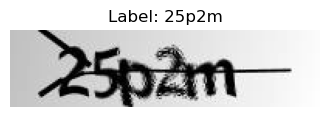

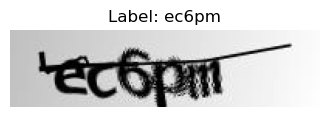

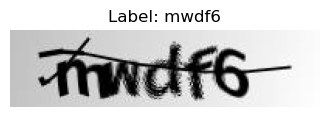

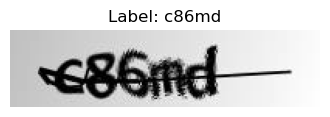

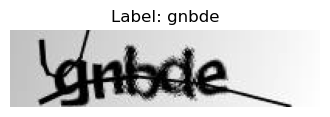

In [86]:
def visualize_random_samples(dataset, int_to_char, num_samples=5):
    """
    Visualize random samples from a dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """

    # Create an iterator for the dataset
    dataset_iter = iter(dataset)

    # Iterate through the random samples and visualize them
    for i in range(num_samples):
        image, label = next(dataset_iter)

        # Decode the label (convert integers to characters)
        label = [int_to_char[int(x)] for x in label[0].numpy()]

        # Display the image and label
        plt.figure(figsize=(4, 2))
        plt.imshow(image[0, :, :, 0], cmap='gray')
        plt.title("Label: " + ''.join(label))
        plt.axis('off')
        plt.show()

# Example usage:
visualize_random_samples(validation_dataset, int_to_char, num_samples=5)

In [87]:
# Define the input layer
input_data = Input(shape=(image_height, image_width, 1), name='input_image')

# Standardize values to be in the [0, 1] range
x = Rescaling(1./255)(input_data)

# Transpose the tensor to shape (None, image_width, image_height, 1)
x = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]), name="transpose")(x)

# Convolutional layers
x = Conv2D(64, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name="pool1")(x)

x = Conv2D(128, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name="pool2")(x)

x = Conv2D(256, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 1), name="pool3")(x) # Pooling over time dimension

x = Reshape(target_shape=(image_width // 8, (image_height // 4) * 256), name="reshape")(x)
x = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = Dropout(0.2)(x)


# Recurrent layers (Bidirectional LSTM)
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)

# Output layer (CTC)
output = Dense(len(all_possible_characters) + 1, activation='softmax')(x)

# Create the model
model = Model(inputs=input_data, outputs=output, name="OCR_model")

# Compile the model with CTC loss
def ctc_loss(y_true, y_pred):
    input_length = tf.fill((batch_size, 1), tf.shape(y_pred)[1])
    label_length = tf.fill((batch_size, 1), max_length)
    loss = ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

model.compile(optimizer=Adam(), loss=ctc_loss)
model.summary()

Model: "OCR_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transpose (Lambda)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 200, 50, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 200, 50, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 25, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 100, 25, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100, 25, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 50, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 25, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 3072)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25, 128)        │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 25, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25, 20)         │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,108 (3.94 MB)

 Trainable params: 1,032,212 (3.94 MB)

 Non-trainable params: 896 (3.50 KB)

In [88]:
num_epochs = 20

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 651ms/step - loss: 21.3812 - val_loss: 16.5525
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 602ms/step - loss: 16.2477 - val_loss: 16.3262
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 683ms/step - loss: 16.1648 - val_loss: 16.2576
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 47s 906ms/step - loss: 16.0667 - val_loss: 15.9420
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - loss: 15.9700 - val_loss: 15.8265
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 46s 769ms/step - loss: 15.6492 - val_loss: 15.2308
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 590ms/step - loss: 15.0335 - val_loss: 9.8410
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 602ms/step - loss: 7.4201 - val_loss: 1.1327
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 751ms/step - loss: 1.3743 - val_loss: 0.4567
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 617ms/step - loss: 0.5221 - val_loss: 0.2988
Epoch 11/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - loss: 0.2962 - val_loss: 0.0852
Epoch 12/20
52/52 ━━━━━━━━━━

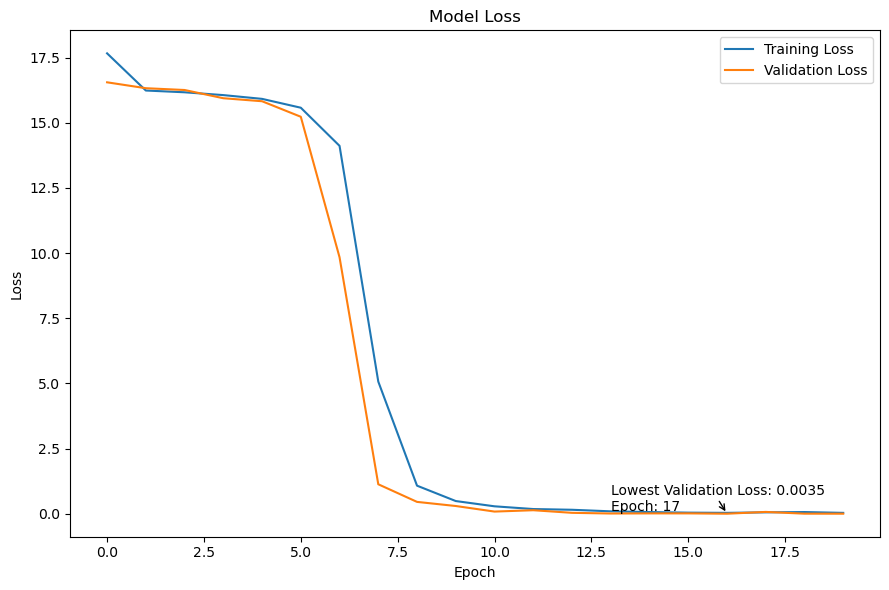

In [89]:
# Find the epoch with the lowest validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))


# Plot training history without accuracy
def plot_training_history(history, best_epoch):
    plt.figure(figsize=(9, 6))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Display the lowest validation loss and the epoch at which it occurred
    min_val_loss = min(history.history['val_loss'])
    plt.annotate(
        f'Lowest Validation Loss: {min_val_loss:.4f}\nEpoch: {best_epoch + 1}',
        xy=(best_epoch, min_val_loss),
        xytext=(best_epoch - 3, min_val_loss + 0.1),  # Adjust text position
        arrowprops=dict(facecolor='black', arrowstyle='->')
    )

    plt.tight_layout()
    plt.show()


plot_training_history(history, best_epoch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


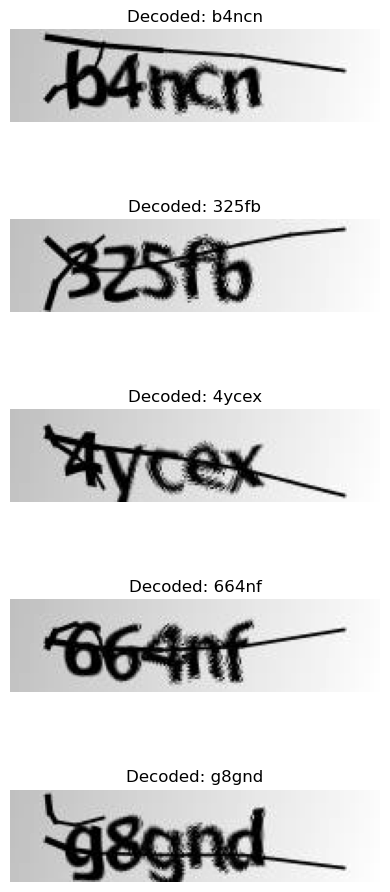

In [90]:
def decode_and_visualize_samples(model, dataset, int_to_char, num_samples=5):
    """
    Decode and visualize random samples from a dataset using the provided model.

    Args:
        model (tf.keras.Model): The CRNN model.
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """

    # Create an iterator for the dataset
    dataset_iter = iter(dataset)

    # Create a subplot grid
    fig, axes = plt.subplots(num_samples, 1, figsize=(4, 2 * num_samples))

    # Iterate through the random samples, decode, and visualize them
    for i in range(num_samples):
        image, label = next(dataset_iter)

        # Make predictions using the model
        predictions = model.predict(image)
        # Decode the predictions using CTC decode
        decoded, _ = ctc_decode(predictions, input_length=tf.fill((batch_size,), 25), greedy=True)

        # Convert decoded labels to characters
        decoded_labels = [int_to_char[int(x)] for x in decoded[0][0,:max_length].numpy()]

        # Display the image and decoded label
        axes[i].imshow(image[0, :, :, 0], cmap='gray')
        axes[i].set_title("Decoded: " + ''.join(decoded_labels))
        axes[i].axis('off')

    # Adjust spacing and display the grid
    plt.tight_layout()
    plt.show()

# Example usage:
decode_and_visualize_samples(model, validation_dataset, int_to_char, num_samples=5)

TESTING OF THE MODEL

In [91]:
# Shuffle the entire dataset before splitting
dataset = dataset.shuffle(buffer_size=len(image_paths), seed=42, reshuffle_each_iteration=False)

# Sizes
total_size = len(image_paths)
train_size = int(0.7 * total_size)       # 70% for training
validation_size = int(0.2 * total_size)  # 20% for validation
test_size = total_size - train_size - validation_size  # remaining 10% for test

# Split dataset
train_dataset = dataset.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = dataset.skip(train_size).take(validation_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset.skip(train_size + validation_size).take(test_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [92]:
def calculate_accuracy(model, dataset, int_to_char):
    total_samples = 0
    correct_predictions = 0

    for batch_images, batch_labels in dataset:
        batch_size = batch_images.shape[0]

        # Get model predictions
        predictions = model.predict(batch_images)

        # Decode predictions
        decoded, _ = ctc_decode(predictions, input_length=tf.fill((batch_size,), predictions.shape[1]), greedy=True)

        for i in range(batch_size):
            pred_indices = decoded[0][i].numpy()
            pred_text = ''.join([int_to_char[idx] for idx in pred_indices if idx != -1])

            true_indices = batch_labels[i].numpy()
            true_text = ''.join([int_to_char[idx] for idx in true_indices])

            if pred_text == true_text:
                correct_predictions += 1
            total_samples += 1

    accuracy = correct_predictions / total_samples
    print(f"Test accuracy: {accuracy * 100:.2f}%")
    return accuracy

calculate_accuracy(model, test_dataset, int_to_char)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test accuracy: 100.00%


1.0